# Experimentos con clasificadores para características manuales
## Adrián Arnaiz
Realizaremos diferentes modelos con diferentes comparadores sobre todos los sets de características que hemos obtenido de manera 'manual' (Disvoice). Realizaremos una comparación para ver cuales nos aportan mejores resultados.

Realizados experimentos con características extraídas directamente de DISVOICE.
> * **Sin añadir edad o sexo al conjunto de atributos.**
> * **Sin estratificar la cross Validation por edad y sexo.** 
> * **Sin dividir los conjuntos de datos por edad o sexo.**

<a id="index"></a>
## Indice de contenido
1. [Implementación experimentador](#imp)
2. [Definición experimento](#def)
3. [Experimenter \ Estandar: Modelos por defecto](#exest)
 1. [Accuracy - atribs. por defecto](#acudef)
 2. [Accuracy - atribs. normalizados](#acunorm)
 3. [AUC - atribs. por defecto](#aucdef)
 4. [Accuracy - atribs. normalizados](#aucnorm)
4. [Grid-Search \ SVM $\rightarrow$ Orozco](#gssvm)
5. [Grid-Search \ PCA - SVM](#gspca)
6. [Grid-Search \ AdaBoost](#gsada)
7. [Selección atributos](#sel)
 1. [Variance Treshold](#vtres)
 2. [Grid-Search \ KBest - AdaBoost](#skbest)


## 1 - Implementación de experimentador <a id="imp"></a><a href="#index"><i class="fa fa-list-alt" aria-hidden="true"></i></a>
Implementamos las funciones neccsarias para realizar un experimentador en python. Para ello seguiremos la estructura realizada en las prácticas de minería de datos realizando algunas modificaciones.

**Metricas para nuestro experimento (Clasificación) = https://scikit-learn.org/stable/modules/model_evaluation.html** (accuracy, recall, roc_auc...)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from cargaDatos import *
import cargaDatos
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import SCORERS, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, chi2
import importlib
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')



In [2]:
def get_datos_generales(experimento):
    general = experimento["GENERAL"]
    return general["ID"], general["N_FOLDS"]


def get_datasets(experimento, norm=False):
    data_nombre = [entry["ID_DATA"] for entry in experimento["DATASETS"]]
    datos_X = []
    datos_Y = []
    for dataset in experimento["DATASETS"]:
        datos = eval(dataset["ORIGIN"]+"()")
        if norm:
            X = datos.data
            sc = MinMaxScaler()
            X_sc = sc.fit(X).transform(X)
            datos_X.append(X_sc)
        else:
            datos_X.append(datos.data)
        datos_Y.append(datos.target)
    return data_nombre,datos_X,datos_Y


def get_algoritmos(experimento):
    instancias= []
    for algo in experimento["ALGORITMOS"]:
        metodo = algo["ALGO"]
        puntos = [pos for pos, char in enumerate(metodo) if char == "."]
        modulo = importlib.import_module(metodo[:puntos[-1]]) #nombre del modulo
        clase = getattr(modulo, metodo[puntos[-1]+1:]) #nombre de la clase
        instancias.append(clase(**algo["PARAMS"]))
        
    return [alg["ID_ALG"] for alg in experimento["ALGORITMOS"]],instancias


def get_output_options(experimento):
    if experimento["OUTPUT"]['DISPLAY'] in ["bar","table", "line"]:
        return experimento["OUTPUT"]['METRIC'],experimento["OUTPUT"]['DISPLAY']
    else:
        print("El modelo de representación debe ser table, line o bar")



def cross_validate_model(X,y,model,num_folds,score):
    if score not in SCORERS.keys():
        raise AttributeError("Atributo score debe ser válido. Ver válidos en sklearn.metrics.SCORERS.keys()")
    print('\t'+str(model)[:20], end=' - ')
    mod_scores = cross_val_score(model,X,y,cv=num_folds,scoring=score)
    print('FM')
    return np.array(mod_scores)

def cross_validate_all_models(data_X,data_y,models,num_folds,score):
    res_exp = []
    for d in range(len(data_names)):
        print(str(d)+' ⟶ '+data_names[d])
        dx = data_X[d]
        dy = data_y[d]
        clone_models = [clone(m) for m in models]
        res_dtset = [cross_validate_model(dx,dy,modl,num_folds,score) for modl in clone_models]
        res_exp.append(np.array(res_dtset))    
        print('Fin Data')
    print('-------------Fin Experimentos-----------')
    return res_exp


def process_results(all_results, data_names, model_names, rep_type):
    
    # los datos son inventados, no tiene porque devolver los datos de ejemplo
    data = [np.mean(res, axis=1) for res in all_results] 
    data.append(np.mean(data,axis=0))
    df = pd.DataFrame(data,
                  columns = model_names,
                  index = data_names+['MEDIA']) 
    if rep_type == "table":
        return df
    else:
        df.plot(kind=rep_type, ylim=(0,1), figsize=(18,9)).legend(bbox_to_anchor=(1.2, 0.5))


## 2 - Definición Experimento <a id="def"></a><a href="#index"><i class="fa fa-list-alt" aria-hidden="true"></i></a>

In [3]:
general = {
    "ID":"ExperimentoBase",
    "N_FOLDS":10
}

datasets = [
    {
        "ID_DATA":"art_rt",
        "ORIGIN":"load_art_rt",
    },
    {
        "ID_DATA":"art_w_atleta",
        "ORIGIN":"load_art_w_atleta",
    },
    {
        "ID_DATA":"art_w_braso",
        "ORIGIN":"load_art_w_braso",
    },
    {
        "ID_DATA":"art_w_campana",
        "ORIGIN":"load_art_w_campana",
    },
    {
        "ID_DATA":"art_w_gato",
        "ORIGIN":"load_art_w_gato",
    },
    {
        "ID_DATA":"art_w_petaka",
        "ORIGIN":"load_art_w_petaka",
    },
    {
        "ID_DATA":"fon_rt",
        "ORIGIN":"load_fon_rt",
    },
    {
        "ID_DATA":"fon_v_A",
        "ORIGIN":"load_fon_v_A",
    },
    {
        "ID_DATA":"fon_v_E",
        "ORIGIN":"load_fon_v_E",
    },
    {
        "ID_DATA":"fon_v_I",
        "ORIGIN":"load_fon_v_I",
    },
    {
        "ID_DATA":"fon_v_O",
        "ORIGIN":"load_fon_v_O",
    },
    {
        "ID_DATA":"fon_v_U",
        "ORIGIN":"load_fon_v_U",
    },
    {
        "ID_DATA":"fon_w_atleta",
        "ORIGIN":"load_fon_w_atleta",
    },
    {
        "ID_DATA":"fon_w_braso",
        "ORIGIN":"load_fon_w_braso",
    },
    {
        "ID_DATA":"fon_w_campana",
        "ORIGIN":"load_fon_w_campana",
    },
    {
        "ID_DATA":"fon_w_gato",
        "ORIGIN":"load_fon_w_gato",
    },
    {
        "ID_DATA":"fon_w_petaka",
        "ORIGIN":"load_fon_w_petaka",
    },
    {
        "ID_DATA":"prs_rt",
        "ORIGIN":"load_prs_rt",
    }

]

algoritmos = [
    {
        "ID_ALG":"KNN8",
        "ALGO": "sklearn.neighbors.KNeighborsClassifier",
        "PARAMS":{
            "n_neighbors":8,
            "metric":"euclidean"
        }
    },
    {
        "ID_ALG":"Tree",
        "ALGO": "sklearn.tree.DecisionTreeClassifier",
        "PARAMS":{  # Parámetros por defecto       
        }
    },
    {
        "ID_ALG":"Bayes",
        "ALGO": "sklearn.naive_bayes.GaussianNB",
        "PARAMS":{  # Parámetros por defecto       
        }
    },
    {
        "ID_ALG":"SVM",
        "ALGO": "sklearn.svm.SVC",
        "PARAMS":{
        }
    },
    {
        "ID_ALG":"RandomF",
        "ALGO": "sklearn.ensemble.RandomForestClassifier",
        "PARAMS":{ 
        }
    },
    {
        "ID_ALG":"Ada",
        "ALGO": "sklearn.ensemble.AdaBoostClassifier",
        "PARAMS":{ 
        }
    },
    {
        "ID_ALG":"Reglas",
        "ALGO": "sklearn.dummy.DummyClassifier",
        "PARAMS":{ 
        }
    },
    {
        "ID_ALG":"GBC",
        "ALGO": "sklearn.ensemble.GradientBoostingClassifier",
        "PARAMS":{ 
        }
    },
    
]

output = {
    "METRIC":"accuracy",
    "DISPLAY":"table"
}

experimento = {
    "GENERAL":general,
    "DATASETS":datasets,
    "ALGORITMOS":algoritmos,
    "OUTPUT": output    
}

## 3 - Ejecución Experimento Estandar: Modelos por defecto <a id="exest"></a><a href="#index"><i class="fa fa-list-alt" aria-hidden="true"></i></a>
### Accuracy - Atributos sin modificar <a id="acudef"></a><a href="#index"><i class="fa fa-list-alt" aria-hidden="true"></i></a>

In [4]:
import warnings
warnings.filterwarnings('ignore')
name_exp,num_folds = get_datos_generales(experimento)
data_names,data_X,data_y = get_datasets(experimento)
model_names,models = get_algoritmos(experimento)
score,rep_type = get_output_options(experimento)
all_results = cross_validate_all_models(data_X,data_y,models,num_folds,score)
clear_output()

In [5]:
process_results(all_results, data_names, model_names, rep_type)

,KNN8,Tree,Bayes,SVM,RandomF,Ada,Reglas,GBC
art_rt,0.420000,0.610000,0.650000,0.500000,0.650000,0.700000,0.490000,0.700000
art_w_atleta,0.660000,0.580000,0.590000,0.500000,0.550000,0.610000,0.470000,0.590000
art_w_braso,0.510000,0.540000,0.640000,0.520000,0.530000,0.520000,0.460000,0.580000
art_w_campana,0.570000,0.550000,0.640000,0.480000,0.570000,0.650000,0.420000,0.580000
art_w_gato,0.520000,0.530000,0.640000,0.520000,0.660000,0.600000,0.600000,0.630000
art_w_petaka,0.510000,0.570000,0.650000,0.470000,0.550000,0.620000,0.450000,0.700000
fon_rt,0.560000,0.600000,0.590000,0.430000,0.560000,0.750000,0.520000,0.650000
fon_v_A,0.653333,0.606667,0.640000,0.573333,0.583333,0.650000,0.446667,0.630000
fon_v_E,0.593333,0.523333,0.650000,0.553333,0.603333,0.590000,0.513333,0.600000
fon_v_I,0.590000,0.586667,0.633333,0.586667,0.610000,0.613333,0.500000,0.616667


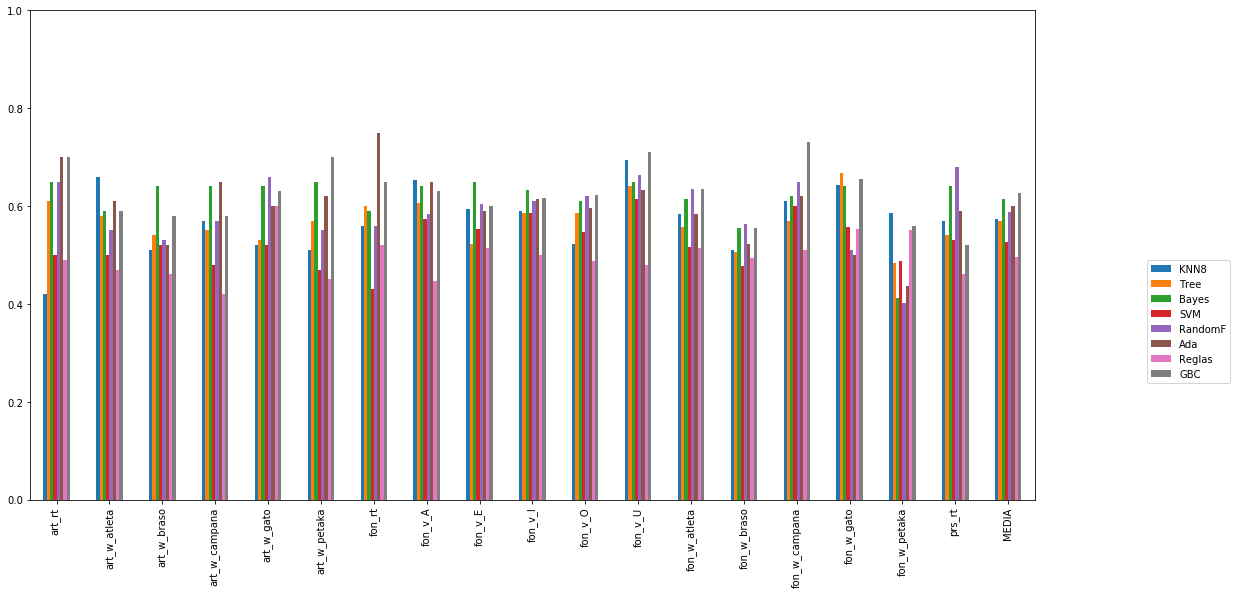

In [6]:
rep_type = "bar"
process_results(all_results, data_names, model_names, rep_type)

### Accuracy - Atributos normalizados <a id="acunorm"></a><a href="#index"><i class="fa fa-list-alt" aria-hidden="true"></i></a>

In [7]:
name_exp,num_folds = get_datos_generales(experimento)
data_names,data_X,data_y = get_datasets(experimento,True)
model_names,models = get_algoritmos(experimento)
score,rep_type = get_output_options(experimento)
all_results = cross_validate_all_models(data_X,data_y,models,num_folds,score)
clear_output()

In [8]:
process_results(all_results, data_names, model_names, rep_type)

,KNN8,Tree,Bayes,SVM,RandomF,Ada,Reglas,GBC
art_rt,0.590000,0.570000,0.650000,0.630000,0.590000,0.700000,0.500000,0.710000
art_w_atleta,0.600000,0.560000,0.590000,0.570000,0.550000,0.610000,0.520000,0.620000
art_w_braso,0.550000,0.570000,0.640000,0.610000,0.620000,0.520000,0.510000,0.590000
art_w_campana,0.580000,0.560000,0.640000,0.570000,0.580000,0.650000,0.510000,0.620000
art_w_gato,0.660000,0.520000,0.640000,0.640000,0.570000,0.600000,0.480000,0.610000
art_w_petaka,0.570000,0.570000,0.650000,0.590000,0.600000,0.620000,0.570000,0.670000
fon_rt,0.510000,0.570000,0.590000,0.550000,0.600000,0.750000,0.450000,0.650000
fon_v_A,0.613333,0.590000,0.640000,0.646667,0.600000,0.650000,0.506667,0.640000
fon_v_E,0.603333,0.560000,0.650000,0.646667,0.646667,0.590000,0.470000,0.600000
fon_v_I,0.590000,0.596667,0.633333,0.640000,0.616667,0.613333,0.513333,0.623333


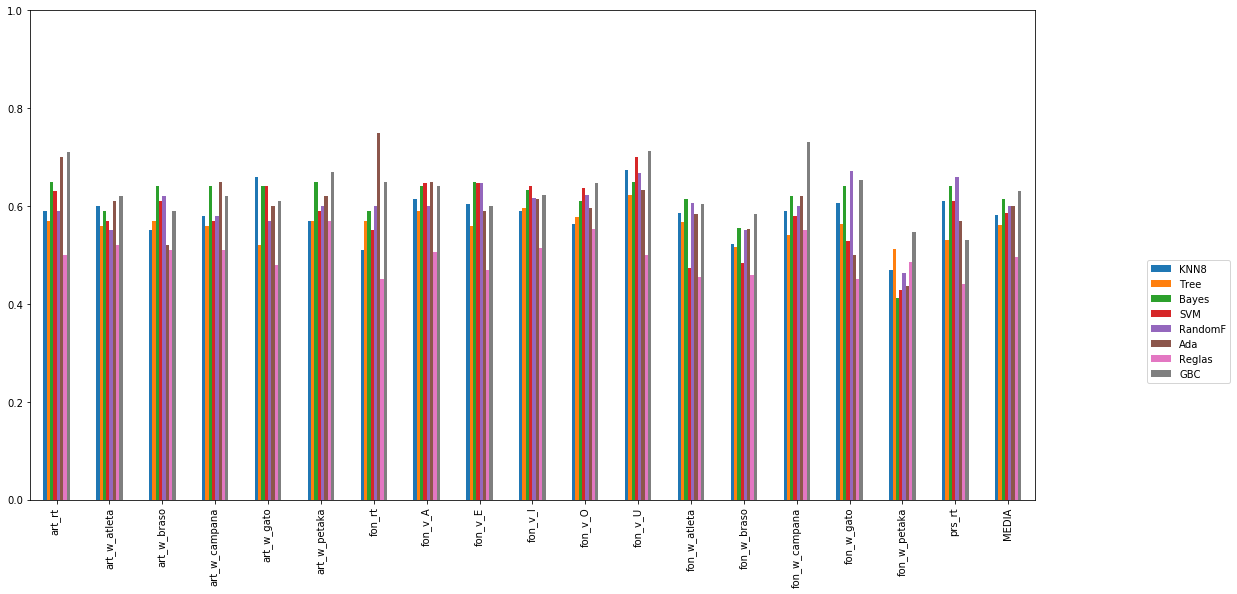

In [9]:
rep_type='bar'
process_results(all_results, data_names, model_names, rep_type)

### AUC - Atributos sin modificar <a id="aucdef"></a><a href="#index"><i class="fa fa-list-alt" aria-hidden="true"></i></a>

In [10]:
experimento['OUTPUT']['METRIC']='roc_auc'

In [11]:
name_exp,num_folds = get_datos_generales(experimento)
data_names,data_X,data_y = get_datasets(experimento)
model_names,models = get_algoritmos(experimento)
score,rep_type = get_output_options(experimento)
all_results = cross_validate_all_models(data_X,data_y,models,num_folds,score)
clear_output()

In [12]:
process_results(all_results, data_names, model_names, rep_type)

,KNN8,Tree,Bayes,SVM,RandomF,Ada,Reglas,GBC
art_rt,0.474000,0.570000,0.694000,0.580000,0.632000,0.784000,0.490000,0.760000
art_w_atleta,0.696000,0.500000,0.640000,0.526000,0.716000,0.708000,0.530000,0.672000
art_w_braso,0.526000,0.600000,0.692000,0.506000,0.680000,0.536000,0.520000,0.596000
art_w_campana,0.598000,0.570000,0.682000,0.514000,0.678000,0.696000,0.490000,0.680000
art_w_gato,0.572000,0.570000,0.672000,0.408000,0.658000,0.616000,0.450000,0.704000
art_w_petaka,0.562000,0.540000,0.716000,0.544000,0.634000,0.632000,0.450000,0.708000
fon_rt,0.542000,0.560000,0.592000,0.416000,0.600000,0.836000,0.500000,0.692000
fon_v_A,0.644667,0.580000,0.701778,0.617111,0.681556,0.694222,0.520000,0.703556
fon_v_E,0.624222,0.550000,0.724222,0.590222,0.689333,0.634889,0.450000,0.656889
fon_v_I,0.628889,0.596667,0.682222,0.633333,0.636444,0.656444,0.466667,0.660444


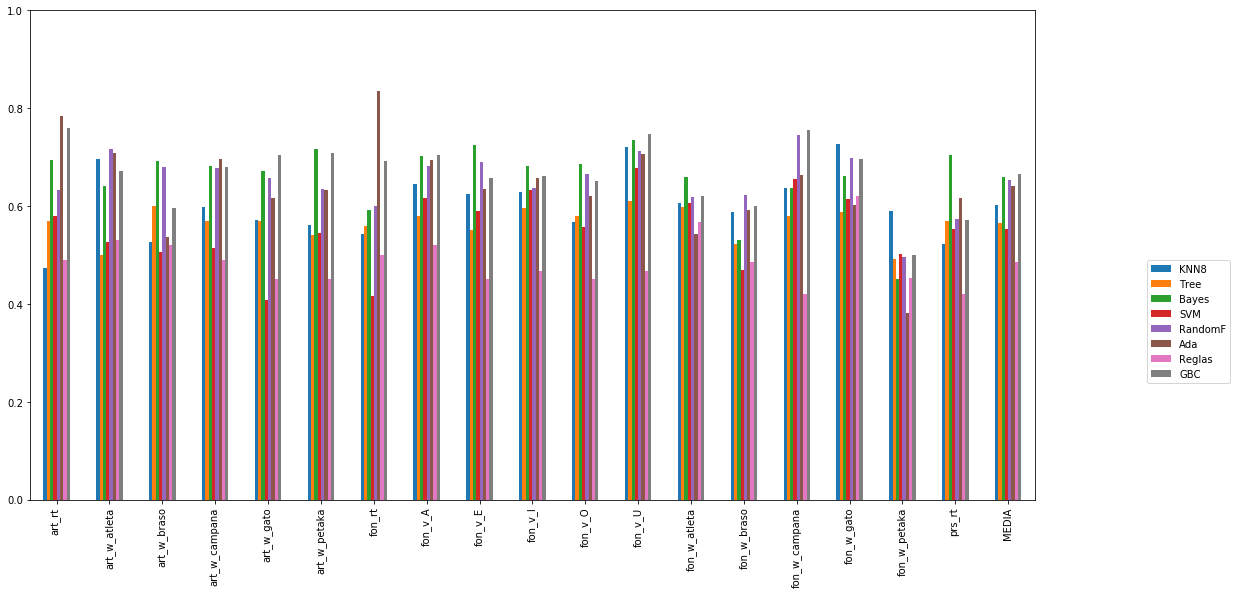

In [13]:
rep_type='bar'
process_results(all_results, data_names, model_names, rep_type)

### AUC - Atributos Normalizados <a id="aucnorm"></a><a href="#index"><i class="fa fa-list-alt" aria-hidden="true"></i></a>

In [14]:
name_exp,num_folds = get_datos_generales(experimento)
data_names,data_X,data_y = get_datasets(experimento, True)
model_names,models = get_algoritmos(experimento)
score,rep_type = get_output_options(experimento)
all_results = cross_validate_all_models(data_X,data_y,models,num_folds,score)
clear_output()

In [15]:
process_results(all_results, data_names, model_names, rep_type)

,KNN8,Tree,Bayes,SVM,RandomF,Ada,Reglas,GBC
art_rt,0.700000,0.540000,0.694000,0.756000,0.664000,0.784000,0.530000,0.756000
art_w_atleta,0.662000,0.550000,0.640000,0.692000,0.608000,0.708000,0.450000,0.688000
art_w_braso,0.582000,0.570000,0.692000,0.680000,0.606000,0.536000,0.490000,0.632000
art_w_campana,0.588000,0.550000,0.678000,0.700000,0.618000,0.696000,0.450000,0.664000
art_w_gato,0.736000,0.540000,0.672000,0.672000,0.640000,0.616000,0.460000,0.700000
art_w_petaka,0.620000,0.600000,0.716000,0.712000,0.656000,0.632000,0.450000,0.692000
fon_rt,0.600000,0.580000,0.592000,0.500000,0.690000,0.836000,0.550000,0.692000
fon_v_A,0.659333,0.606667,0.701333,0.727111,0.686444,0.694667,0.480000,0.706222
fon_v_E,0.631111,0.563333,0.724222,0.745778,0.696444,0.634889,0.516667,0.669333
fon_v_I,0.654000,0.593333,0.682222,0.718667,0.632222,0.656444,0.530000,0.664444


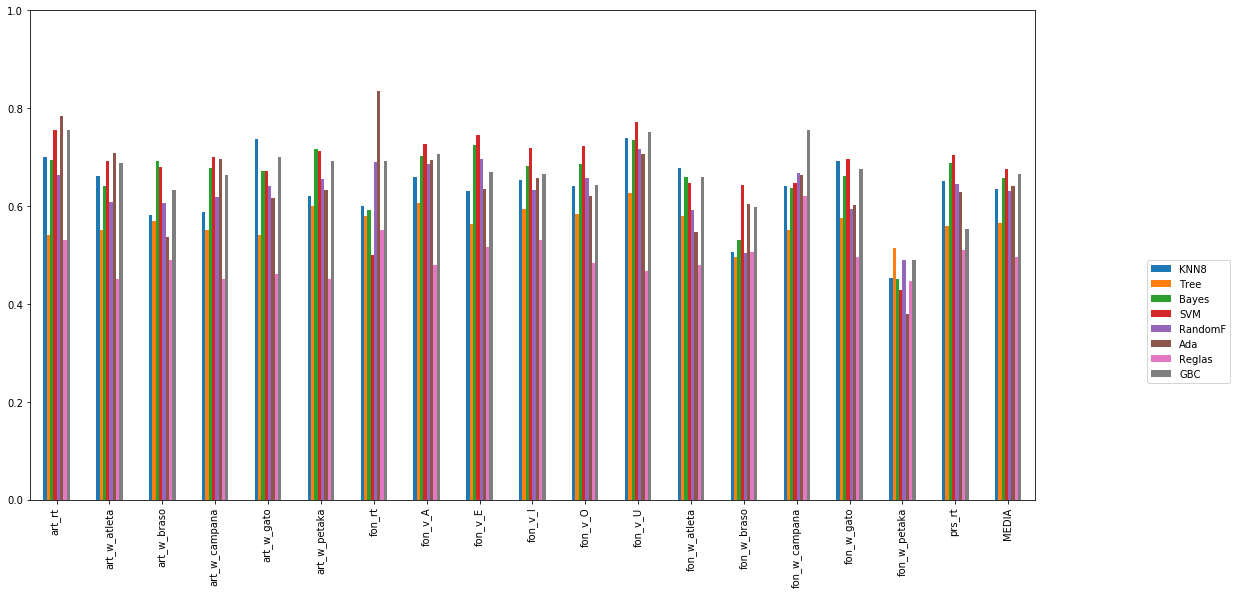

In [16]:
rep_type='bar'
process_results(all_results, data_names, model_names, rep_type)

-------------

In [17]:
experimento['OUTPUT']['METRIC']='accuracy'

## 4 - Experimento artículo 2016 Orozco: SVM con kernel gaussiano haciendo gridSearch de parámetros C y $\gamma$ realizando 10-fold cross-validation <a id="gssvm"></a><a href="#index"><i class="fa fa-list-alt" aria-hidden="true"></i></a>
#### Primero realizamos función que realizará la optimización de parámetros con GridSearch para cada uno de los diferentes conjuntos de atributos. Devuelve:
> * **mejores** = diccionario cuyas claves son el nombre de los sets de caracteristicas y contiene para cada set:
 * *score* = score del mejor conjunto de parametros para ese set de ccas.
 * *params* = parametros que consiguen el mejor score para ese conunto.
 * *results* = clf.cv_results_ para el experimento  de gridsearch de ese dataset


In [18]:
def GridSearchPipe(pipe,pg):
    mejores=dict()

    for dtst in [ d for d in dir(cargaDatos) if d.startswith('load')]:
        datos = eval(dtst+'()')
        X = datos.data
        y = datos.target
        sc = MinMaxScaler()
        X = sc.fit(X).transform(X) #Comentar para no normalizar

        clf = GridSearchCV(pipe, cv=10, param_grid=pg)
        clf.fit(X,y)

        print('\n------------------------\nDataset:',dtst[5:])
        print("Los mejores parámetros encontrados son:")
        print()
        print(clf.best_params_,end=' - score: ')
        print(clf.best_score_)
        mejores[dtst[5:]]={'score':clf.best_score_, 'params':clf.best_params_, 'results':clf.cv_results_}
        print()
        print("Rejilla de scores de cada una de las combinaciones de parámetros:")

        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))
        print()

    return mejores

#### Funcion que pasa el diccionario *mejores* a un dataframe para la mejor visualización de los reultados

In [19]:
def best_to_panda(mej):
    mejores_ordenados = [(mej[m]['score'], mej[m]['params'], m) for m in sorted(mej, key=lambda x: mej[x]['score'], reverse=True)]
    return pd.DataFrame(columns = ['score','params','dtst'], data=mejores_ordenados).set_index('dtst')

#### Realizamos el experimento de orozco. 
SVM con gridSearch de C y $\gamma$

In [20]:
param_grid = [
      {'C': [1, 10, 100, 1000, 10000], 'kernel': ['rbf'], 'gamma' : [1000,100,10,1]},
 ]

bestsOrz = GridSearchPipe(svm.SVC(),param_grid)


------------------------
Dataset: art_rt
Los mejores parámetros encontrados son:

{'C': 1, 'gamma': 10, 'kernel': 'rbf'} - score: 0.6

Rejilla de scores de cada una de las combinaciones de parámetros:
0.500 (+/-0.000) for {'C': 1, 'gamma': 1000, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 1, 'gamma': 100, 'kernel': 'rbf'}
0.600 (+/-0.237) for {'C': 1, 'gamma': 10, 'kernel': 'rbf'}
0.590 (+/-0.275) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 10, 'gamma': 1000, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 10, 'gamma': 100, 'kernel': 'rbf'}
0.600 (+/-0.237) for {'C': 10, 'gamma': 10, 'kernel': 'rbf'}
0.540 (+/-0.256) for {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 100, 'gamma': 1000, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 100, 'gamma': 100, 'kernel': 'rbf'}
0.600 (+/-0.237) for {'C': 100, 'gamma': 10, 'kernel': 'rbf'}
0.540 (+/-0.256) for {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
0.500 (+/-0.000) for {'C': 1000, 'gamma': 1000, 'kernel': 'r


------------------------
Dataset: fon_rt
Los mejores parámetros encontrados son:

{'C': 1, 'gamma': 1, 'kernel': 'rbf'} - score: 0.66

Rejilla de scores de cada una de las combinaciones de parámetros:
0.580 (+/-0.294) for {'C': 1, 'gamma': 1000, 'kernel': 'rbf'}
0.530 (+/-0.092) for {'C': 1, 'gamma': 100, 'kernel': 'rbf'}
0.560 (+/-0.382) for {'C': 1, 'gamma': 10, 'kernel': 'rbf'}
0.660 (+/-0.256) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.580 (+/-0.294) for {'C': 10, 'gamma': 1000, 'kernel': 'rbf'}
0.520 (+/-0.080) for {'C': 10, 'gamma': 100, 'kernel': 'rbf'}
0.560 (+/-0.402) for {'C': 10, 'gamma': 10, 'kernel': 'rbf'}
0.520 (+/-0.280) for {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
0.580 (+/-0.294) for {'C': 100, 'gamma': 1000, 'kernel': 'rbf'}
0.520 (+/-0.080) for {'C': 100, 'gamma': 100, 'kernel': 'rbf'}
0.560 (+/-0.402) for {'C': 100, 'gamma': 10, 'kernel': 'rbf'}
0.510 (+/-0.275) for {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
0.580 (+/-0.294) for {'C': 1000, 'gamma': 1000, 'kernel': 'r


------------------------
Dataset: fon_w_atleta
Los mejores parámetros encontrados son:

{'C': 1, 'gamma': 1, 'kernel': 'rbf'} - score: 0.5959595959595959

Rejilla de scores de cada una de las combinaciones de parámetros:
0.505 (+/-0.032) for {'C': 1, 'gamma': 1000, 'kernel': 'rbf'}
0.505 (+/-0.032) for {'C': 1, 'gamma': 100, 'kernel': 'rbf'}
0.455 (+/-0.266) for {'C': 1, 'gamma': 10, 'kernel': 'rbf'}
0.596 (+/-0.285) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.505 (+/-0.032) for {'C': 10, 'gamma': 1000, 'kernel': 'rbf'}
0.505 (+/-0.032) for {'C': 10, 'gamma': 100, 'kernel': 'rbf'}
0.495 (+/-0.345) for {'C': 10, 'gamma': 10, 'kernel': 'rbf'}
0.576 (+/-0.274) for {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
0.505 (+/-0.032) for {'C': 100, 'gamma': 1000, 'kernel': 'rbf'}
0.505 (+/-0.032) for {'C': 100, 'gamma': 100, 'kernel': 'rbf'}
0.495 (+/-0.345) for {'C': 100, 'gamma': 10, 'kernel': 'rbf'}
0.556 (+/-0.314) for {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
0.505 (+/-0.032) for {'C': 1000, 'gamma'

In [21]:
best_to_panda(bestsOrz)

,score,params
dtst,,
fon_v_U,0.710000,"{'C': 10, 'gamma': 10, 'kernel': 'rbf'}"
fon_w_campana,0.710000,"{'C': 1, 'gamma': 1000, 'kernel': 'rbf'}"
fon_v_E,0.673333,"{'C': 1, 'gamma': 1, 'kernel': 'rbf'}"
prs_rt,0.670000,"{'C': 10, 'gamma': 1, 'kernel': 'rbf'}"
fon_rt,0.660000,"{'C': 1, 'gamma': 1, 'kernel': 'rbf'}"
fon_w_gato,0.657895,"{'C': 10, 'gamma': 1, 'kernel': 'rbf'}"
fon_v_A,0.656667,"{'C': 1, 'gamma': 1, 'kernel': 'rbf'}"
fon_v_O,0.636667,"{'C': 1, 'gamma': 1, 'kernel': 'rbf'}"
fon_v_I,0.613333,"{'C': 1, 'gamma': 1, 'kernel': 'rbf'}"


**#Veo que los mean_train_score son 1 y los Mean_test_score son bajos = ¿SOBREAJUSTE?**

In [22]:
bestsOrz['art_w_petaka']['results']

{'mean_fit_time': array([0.00459664, 0.00801437, 0.00362468, 0.00468712, 0.00312479,
        0.00522366, 0.00468755, 0.00781214, 0.00468724, 0.00867293,
        0.00624981, 0.00624917, 0.00312479, 0.00834839, 0.00468719,
        0.00468712, 0.00781195, 0.00386071, 0.00468926, 0.00527692]),
 'std_fit_time': array([0.00346752, 0.00359601, 0.00617953, 0.00715969, 0.00624957,
        0.00571166, 0.00716035, 0.00781214, 0.00715987, 0.00774854,
        0.00765442, 0.00765363, 0.00624957, 0.00624784, 0.0071598 ,
        0.00715969, 0.00781195, 0.00477335, 0.00716297, 0.00699018]),
 'mean_score_time': array([0.00236244, 0.00109966, 0.00166237, 0.0015624 , 0.0015624 ,
        0.00030022, 0.        , 0.        , 0.00156236, 0.00206223,
        0.00156226, 0.0015624 , 0.0015624 , 0.00186248, 0.004687  ,
        0.0015624 , 0.        , 0.00356953, 0.00156245, 0.00166252]),
 'std_score_time': array([0.00447542, 0.00053773, 0.00466328, 0.00468721, 0.00468721,
        0.00045859, 0.        , 0.      

------------------
## 5 -   PCA - SVM / GridSearch <a id="gspca"></a><a href="#index"><i class="fa fa-list-alt" aria-hidden="true"></i></a>
GridSearch de reducción de dimensionalidad

In [23]:
param_grid = dict(reduce_dim__n_components=range(5,28,3), clf__C=[100,10,1], clf__gamma=[100,10,1])
estimators = [('reduce_dim', PCA()), ('clf', svm.SVC())]
pipSvm_pca= Pipeline(estimators)
bestsPCA_SVM = GridSearchPipe(pipSvm_pca,param_grid)


------------------------
Dataset: art_rt
Los mejores parámetros encontrados son:

{'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 11} - score: 0.64

Rejilla de scores de cada una de las combinaciones de parámetros:
0.490 (+/-0.108) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 5}
0.490 (+/-0.060) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 8}
0.640 (+/-0.240) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 11}
0.620 (+/-0.377) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 14}
0.590 (+/-0.260) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 17}
0.580 (+/-0.250) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 20}
0.610 (+/-0.244) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 23}
0.610 (+/-0.227) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 26}
0.540 (+/-0.240) for {'clf__C': 100, 'clf__gamma': 10, 'reduce_dim_


------------------------
Dataset: art_w_braso
Los mejores parámetros encontrados son:

{'clf__C': 100, 'clf__gamma': 1, 'reduce_dim__n_components': 5} - score: 0.65

Rejilla de scores de cada una de las combinaciones de parámetros:
0.530 (+/-0.180) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 5}
0.510 (+/-0.108) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 8}
0.520 (+/-0.150) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 11}
0.530 (+/-0.156) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 14}
0.500 (+/-0.089) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 17}
0.510 (+/-0.108) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 20}
0.510 (+/-0.108) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 23}
0.500 (+/-0.089) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 26}
0.570 (+/-0.269) for {'clf__C': 100, 'clf__gamma': 10, 'reduce_di


------------------------
Dataset: art_w_gato
Los mejores parámetros encontrados son:

{'clf__C': 1, 'clf__gamma': 1, 'reduce_dim__n_components': 5} - score: 0.7

Rejilla de scores de cada una de las combinaciones de parámetros:
0.540 (+/-0.098) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 5}
0.550 (+/-0.100) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 8}
0.520 (+/-0.080) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 11}
0.530 (+/-0.128) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 14}
0.530 (+/-0.128) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 17}
0.530 (+/-0.128) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 20}
0.530 (+/-0.128) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 23}
0.530 (+/-0.128) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 26}
0.550 (+/-0.272) for {'clf__C': 100, 'clf__gamma': 10, 'reduce_dim__n


------------------------
Dataset: fon_rt
Los mejores parámetros encontrados son:

{'clf__C': 1, 'clf__gamma': 1, 'reduce_dim__n_components': 11} - score: 0.69

Rejilla de scores de cada una de las combinaciones de parámetros:
0.550 (+/-0.161) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 5}
0.530 (+/-0.092) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 8}
0.530 (+/-0.180) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 11}
0.540 (+/-0.223) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 14}
0.520 (+/-0.120) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 17}
0.510 (+/-0.108) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 20}
0.520 (+/-0.080) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 23}
0.520 (+/-0.080) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 26}
0.640 (+/-0.183) for {'clf__C': 100, 'clf__gamma': 10, 'reduce_dim__n_c


------------------------
Dataset: fon_v_E
Los mejores parámetros encontrados son:

{'clf__C': 1, 'clf__gamma': 1, 'reduce_dim__n_components': 23} - score: 0.6733333333333333

Rejilla de scores de cada una de las combinaciones de parámetros:
0.597 (+/-0.159) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 5}
0.550 (+/-0.174) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 8}
0.550 (+/-0.141) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 11}
0.547 (+/-0.134) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 14}
0.533 (+/-0.133) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 17}
0.520 (+/-0.144) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 20}
0.523 (+/-0.152) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 23}
0.523 (+/-0.161) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 26}
0.587 (+/-0.217) for {'clf__C': 100, 'clf__gamma': 10, '


------------------------
Dataset: fon_v_O
Los mejores parámetros encontrados son:

{'clf__C': 1, 'clf__gamma': 1, 'reduce_dim__n_components': 11} - score: 0.6533333333333333

Rejilla de scores de cada una de las combinaciones de parámetros:
0.547 (+/-0.184) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 5}
0.560 (+/-0.133) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 8}
0.517 (+/-0.161) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 11}
0.497 (+/-0.172) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 14}
0.450 (+/-0.172) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 17}
0.453 (+/-0.095) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 20}
0.453 (+/-0.095) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 23}
0.450 (+/-0.100) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 26}
0.497 (+/-0.153) for {'clf__C': 100, 'clf__gamma': 10, '


------------------------
Dataset: fon_w_atleta
Los mejores parámetros encontrados son:

{'clf__C': 1, 'clf__gamma': 1, 'reduce_dim__n_components': 5} - score: 0.6666666666666666

Rejilla de scores de cada una de las combinaciones de parámetros:
0.586 (+/-0.182) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 5}
0.525 (+/-0.082) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 8}
0.505 (+/-0.032) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 11}
0.505 (+/-0.032) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 14}
0.505 (+/-0.032) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 17}
0.505 (+/-0.032) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 20}
0.505 (+/-0.032) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 23}
0.505 (+/-0.032) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 26}
0.626 (+/-0.225) for {'clf__C': 100, 'clf__gamma': 1


------------------------
Dataset: fon_w_campana
Los mejores parámetros encontrados son:

{'clf__C': 100, 'clf__gamma': 10, 'reduce_dim__n_components': 8} - score: 0.67

Rejilla de scores de cada una de las combinaciones de parámetros:
0.500 (+/-0.200) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 5}
0.490 (+/-0.108) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 8}
0.490 (+/-0.108) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 11}
0.500 (+/-0.155) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 14}
0.490 (+/-0.108) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 17}
0.490 (+/-0.108) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 20}
0.490 (+/-0.108) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 23}
0.490 (+/-0.108) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 26}
0.570 (+/-0.310) for {'clf__C': 100, 'clf__gamma': 10, 'reduce


------------------------
Dataset: fon_w_petaka
Los mejores parámetros encontrados son:

{'clf__C': 10, 'clf__gamma': 1, 'reduce_dim__n_components': 8} - score: 0.625

Rejilla de scores de cada una de las combinaciones de parámetros:
0.500 (+/-0.158) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 5}
0.521 (+/-0.081) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 8}
0.510 (+/-0.061) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 11}
0.510 (+/-0.061) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 14}
0.490 (+/-0.061) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 17}
0.500 (+/-0.091) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 20}
0.510 (+/-0.061) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 23}
0.510 (+/-0.061) for {'clf__C': 100, 'clf__gamma': 100, 'reduce_dim__n_components': 26}
0.500 (+/-0.316) for {'clf__C': 100, 'clf__gamma': 10, 'reduce_d

In [24]:
best_to_panda(bestsPCA_SVM)

,score,params
dtst,,
fon_v_U,0.730000,"{'clf__C': 1, 'clf__gamma': 10, 'reduce_dim__n..."
art_w_gato,0.700000,"{'clf__C': 1, 'clf__gamma': 1, 'reduce_dim__n_..."
fon_rt,0.690000,"{'clf__C': 1, 'clf__gamma': 1, 'reduce_dim__n_..."
prs_rt,0.680000,"{'clf__C': 1, 'clf__gamma': 10, 'reduce_dim__n..."
fon_v_E,0.673333,"{'clf__C': 1, 'clf__gamma': 1, 'reduce_dim__n_..."
fon_w_campana,0.670000,"{'clf__C': 100, 'clf__gamma': 10, 'reduce_dim_..."
fon_w_atleta,0.666667,"{'clf__C': 1, 'clf__gamma': 1, 'reduce_dim__n_..."
fon_v_I,0.660000,"{'clf__C': 1, 'clf__gamma': 1, 'reduce_dim__n_..."
fon_w_gato,0.657895,"{'clf__C': 100, 'clf__gamma': 1, 'reduce_dim__..."


## 6 - AdaBoost /GS <a id="gsada"></a><a href="#index"><i class="fa fa-list-alt" aria-hidden="true"></i></a>

In [25]:
param_grid = dict(n_estimators=[50, 100, 200])

bestsAda = GridSearchPipe(AdaBoostClassifier(),param_grid)


------------------------
Dataset: art_rt
Los mejores parámetros encontrados son:

{'n_estimators': 200} - score: 0.71

Rejilla de scores de cada una de las combinaciones de parámetros:
0.700 (+/-0.200) for {'n_estimators': 50}
0.690 (+/-0.352) for {'n_estimators': 100}
0.710 (+/-0.316) for {'n_estimators': 200}


------------------------
Dataset: art_w_atleta
Los mejores parámetros encontrados son:

{'n_estimators': 100} - score: 0.7

Rejilla de scores de cada una de las combinaciones de parámetros:
0.610 (+/-0.316) for {'n_estimators': 50}
0.700 (+/-0.237) for {'n_estimators': 100}
0.700 (+/-0.283) for {'n_estimators': 200}


------------------------
Dataset: art_w_braso
Los mejores parámetros encontrados son:

{'n_estimators': 200} - score: 0.65

Rejilla de scores de cada una de las combinaciones de parámetros:
0.520 (+/-0.265) for {'n_estimators': 50}
0.550 (+/-0.241) for {'n_estimators': 100}
0.650 (+/-0.257) for {'n_estimators': 200}


------------------------
Dataset: art_w_camp

In [26]:
best_to_panda(bestsAda)

,score,params
dtst,,
fon_rt,0.750000,{'n_estimators': 50}
art_rt,0.710000,{'n_estimators': 200}
art_w_atleta,0.700000,{'n_estimators': 100}
art_w_campana,0.690000,{'n_estimators': 200}
fon_v_U,0.673333,{'n_estimators': 100}
art_w_petaka,0.670000,{'n_estimators': 200}
art_w_braso,0.650000,{'n_estimators': 200}
fon_v_A,0.650000,{'n_estimators': 50}
fon_w_campana,0.650000,{'n_estimators': 100}


## 7 - Seleccion Atributos <a id="sel"></a><a href="#index"><i class="fa fa-list-alt" aria-hidden="true"></i></a>
### 7.1 Variance Treshold <a id="vtres"></a><a href="#index"><i class="fa fa-list-alt" aria-hidden="true"></i></a>

In [27]:
from sklearn.feature_selection import VarianceThreshold

def seleccion_atribs_pipe(selector, clsf):
    res=[]
    for dtst in [ d for d in dir(cargaDatos) if d.startswith('load')]:
        datos = eval(dtst+'()')
        X = datos.data
        y = datos.target
        sc = MinMaxScaler()
        X = sc.fit(X).transform(X) if clsf != 'AdaBoostClassifier' else X #Comentar para no normalizar
        params = 'chi2, K=19' if selector == 'SelectKBest' else ''
        params = 'threshold=(0.1)' if selector == 'VarianceThreshold' and clsf == 'AdaBoostClassifier' else ''
        estimators = [('feat_sel', eval(selector+'('+params+')')), ('clf', eval(clsf+'()'))]
        pipe = Pipeline(estimators)
        sc=cross_val_score(pipe, X, y, cv=10, scoring='roc_auc').mean()
        res.append(sc)
    return res

In [28]:
df_VT = pd.DataFrame(index=[ d[5:] for d in dir(cargaDatos) if d.startswith('load')])
clasificadores = ['AdaBoostClassifier', 'GradientBoostingClassifier', 'svm.SVC', 'RandomForestClassifier']
for clf in clasificadores:
    res= seleccion_atribs_pipe('VarianceThreshold',clf)
    df_VT[clf[:7]]= pd.DataFrame(res,[ d[5:] for d in dir(cargaDatos) if d.startswith('load')],columns=[clf[:7]])
df_VT

,AdaBoos,Gradien,svm.SVC,RandomF
art_rt,0.760000,0.800000,0.756000,0.638000
art_w_atleta,0.672000,0.692000,0.692000,0.646000
art_w_braso,0.544000,0.640000,0.680000,0.538000
art_w_campana,0.692000,0.660000,0.700000,0.590000
art_w_gato,0.612000,0.696000,0.672000,0.622000
art_w_petaka,0.580000,0.704000,0.712000,0.608000
fon_rt,0.884000,0.684000,0.500000,0.658000
fon_v_A,0.689333,0.708889,0.727111,0.680444
fon_v_E,0.652000,0.658222,0.745778,0.692222
fon_v_I,0.645778,0.667556,0.718667,0.655556


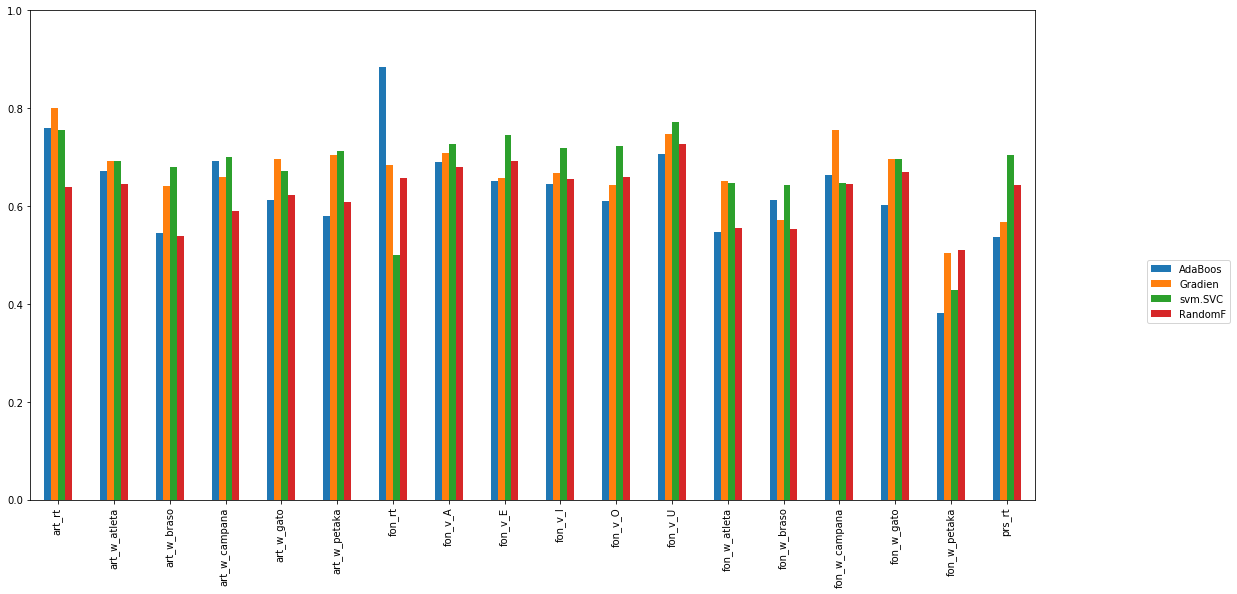

In [29]:
df_VT.plot(kind='bar', ylim=(0,1), figsize=(18,9)).legend(bbox_to_anchor=(1.2, 0.5))

### 7.2 Select K-Best - AdaBoost - GridSearch <a id="skbest"></a><a href="#index"><i class="fa fa-list-alt" aria-hidden="true"></i></a>
Se buscará el número de características óptimo den  entre 9 y 25 con el algoritmo de selección de características K-Best y el clasificador AdaBoost que es el que mejor nos está funcionando.

In [30]:
param_grid = dict(select__k=range(9,25,3))

pipe=Pipeline([('norm',MinMaxScaler()), ('select',SelectKBest(chi2, k=10)), ('clf',AdaBoostClassifier())])

bestsAda_Sk = GridSearchPipe(pipe,param_grid)


------------------------
Dataset: art_rt
Los mejores parámetros encontrados son:

{'select__k': 21} - score: 0.73

Rejilla de scores de cada una de las combinaciones de parámetros:
0.660 (+/-0.286) for {'select__k': 9}
0.670 (+/-0.237) for {'select__k': 12}
0.710 (+/-0.244) for {'select__k': 15}
0.670 (+/-0.297) for {'select__k': 18}
0.730 (+/-0.297) for {'select__k': 21}
0.700 (+/-0.438) for {'select__k': 24}


------------------------
Dataset: art_w_atleta
Los mejores parámetros encontrados son:

{'select__k': 12} - score: 0.55

Rejilla de scores de cada una de las combinaciones de parámetros:
0.510 (+/-0.166) for {'select__k': 9}
0.550 (+/-0.205) for {'select__k': 12}
0.490 (+/-0.260) for {'select__k': 15}
0.550 (+/-0.257) for {'select__k': 18}
0.500 (+/-0.297) for {'select__k': 21}
0.520 (+/-0.280) for {'select__k': 24}


------------------------
Dataset: art_w_braso
Los mejores parámetros encontrados son:

{'select__k': 9} - score: 0.62

Rejilla de scores de cada una de las combi

In [31]:
best_to_panda(bestsAda_Sk)

,score,params
dtst,,
art_rt,0.730000,{'select__k': 21}
art_w_gato,0.690000,{'select__k': 21}
fon_v_U,0.683333,{'select__k': 18}
fon_rt,0.680000,{'select__k': 21}
fon_w_campana,0.650000,{'select__k': 15}
fon_v_A,0.640000,{'select__k': 24}
fon_v_I,0.633333,{'select__k': 15}
art_w_braso,0.620000,{'select__k': 9}
art_w_campana,0.620000,{'select__k': 9}


### 7.3 Select K-Best 

In [32]:
df_SK = pd.DataFrame(index=[ d[5:] for d in dir(cargaDatos) if d.startswith('load')])
clasificadores = ['AdaBoostClassifier', 'GradientBoostingClassifier', 'svm.SVC', 'RandomForestClassifier']
for clf in clasificadores:
    res= seleccion_atribs_pipe('SelectKBest',clf)
    df_SK[clf[:7]]= pd.DataFrame(res,[ d[5:] for d in dir(cargaDatos) if d.startswith('load')],columns=[clf[:7]])
df_SK

,AdaBoos,Gradien,svm.SVC,RandomF
art_rt,0.666000,0.652000,0.756000,0.634000
art_w_atleta,0.556000,0.568000,0.712000,0.592000
art_w_braso,0.556000,0.540000,0.640000,0.552000
art_w_campana,0.570000,0.650000,0.660000,0.572000
art_w_gato,0.544000,0.636000,0.704000,0.618000
art_w_petaka,0.536000,0.496000,0.664000,0.586000
fon_rt,0.516000,0.596000,0.472000,0.474000
fon_v_A,0.665778,0.662222,0.727111,0.700667
fon_v_E,0.674444,0.688000,0.757778,0.681111
fon_v_I,0.659556,0.667111,0.740000,0.651778


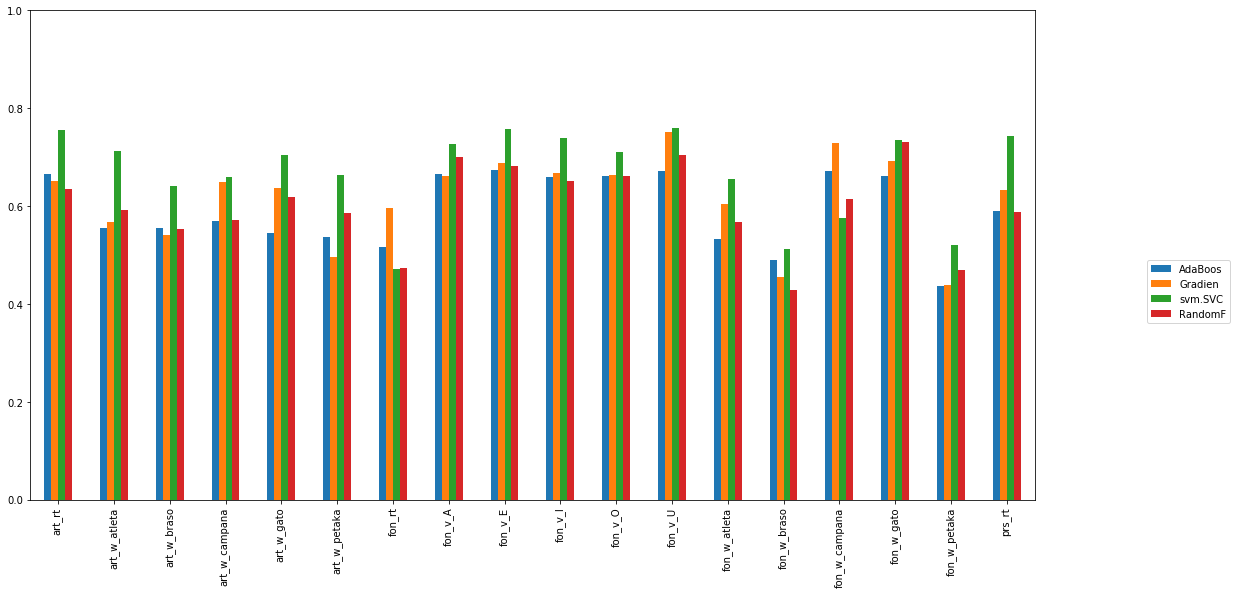

In [33]:
df_SK.plot(kind='bar', ylim=(0,1), figsize=(18,9)).legend(bbox_to_anchor=(1.2, 0.5))

## Matrices de confusión para AdaBoost

In [34]:
import seaborn as sns; sns.set()

def matrix_conf(datos):
    datos = eval(datos+'()')
    X = datos.data
    y = datos.target
    sc = MinMaxScaler()
    X = sc.fit(X).transform(X) #Comentar para no normalizar

    classifier = AdaBoostClassifier()

    # Se obtienen predicciones mediante validación cruzada 10 folds
    predicted = cross_val_predict(classifier, X, y, cv=10)

    # Se obtiene la matriz de confusión a partir de las predicciones y los valores reales
    cnf_matrix = confusion_matrix(y, predicted)

    conf_mat_df = pd.DataFrame(cnf_matrix,
                               index=['HC','PD'],
                               columns=['HC','PD'])


    return conf_mat_df


In [35]:
for dtst in [ d for d in dir(cargaDatos) if d.startswith('load')]:
    print(dtst, end='')
    tabla = matrix_conf(dtst)
    display(tabla)
    print('--------------------')
    print()

load_art_rt

,HC,PD
HC,34,16
PD,14,36


--------------------

load_art_w_atleta

,HC,PD
HC,30,20
PD,19,31


--------------------

load_art_w_braso

,HC,PD
HC,26,24
PD,24,26


--------------------

load_art_w_campana

,HC,PD
HC,32,18
PD,17,33


--------------------

load_art_w_gato

,HC,PD
HC,29,21
PD,19,31


--------------------

load_art_w_petaka

,HC,PD
HC,32,18
PD,20,30


--------------------

load_fon_rt

,HC,PD
HC,40,10
PD,15,35


--------------------

load_fon_v_A

,HC,PD
HC,104,46
PD,59,91


--------------------

load_fon_v_E

,HC,PD
HC,87,63
PD,60,90


--------------------

load_fon_v_I

,HC,PD
HC,90,60
PD,56,94


--------------------

load_fon_v_O

,HC,PD
HC,91,59
PD,62,88


--------------------

load_fon_v_U

,HC,PD
HC,104,46
PD,64,86


--------------------

load_fon_w_atleta

,HC,PD
HC,27,23
PD,18,31


--------------------

load_fon_w_braso

,HC,PD
HC,30,18
PD,23,26


--------------------

load_fon_w_campana

,HC,PD
HC,31,19
PD,19,31


--------------------

load_fon_w_gato

,HC,PD
HC,22,18
PD,20,16


--------------------

load_fon_w_petaka

,HC,PD
HC,21,27
PD,28,20


--------------------

load_prs_rt

,HC,PD
HC,30,20
PD,21,29


--------------------



## MEJOR - ADA (Sin normalizar) - VT

In [36]:
fonacion_frase = load_fon_rt()
X = fonacion_frase.data
y = fonacion_frase.target
params = dict(select__threshold=[0.01, 0.05, 0.8, 1, 0.13, 0.16, 0.2, 0.25, 0.3 ])
pip = Pipeline([('select', VarianceThreshold()), ('clf', AdaBoostClassifier())])
gs = GridSearchCV(pip,params,cv=10,scoring='roc_auc')
gs.fit(X,y)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('select', VarianceThreshold(threshold=0.0)), ('clf', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'select__threshold': [0.01, 0.05, 0.8, 1, 0.13, 0.16, 0.2, 0.25, 0.3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [37]:
gs.best_params_
gs.best_score_

0.888

In [38]:
fonacion_frase = load_fon_rt()
X = fonacion_frase.data
y = fonacion_frase.target

sel = VarianceThreshold(threshold=(0.2))
X_r_s = sel.fit_transform(X)

ada = AdaBoostClassifier()
predicted = cross_val_predict(ada, X_r_s, y, cv=10)
score = cross_val_score(ada, X_r_s, y, cv=10, scoring='roc_auc').mean()
cnf_matrix = confusion_matrix(y, predicted)

conf_mat_df = pd.DataFrame(cnf_matrix,
                           index=['HC','PD'],
                           columns=['HC','PD'])
print('AUC =',score)
conf_mat_df

AUC = 0.8880000000000002


,HC,PD
HC,38,12
PD,9,41
